# Case

### Scenario
A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

### Goal
Evaluate A/B testing results and decide which marketing strategy works the best.


### Data Dictionary
- MarketID: unique identifier for market
- MarketSize: size of market area by sales
- LocationID: unique identifier for store location
- AgeOfStore: age of store in years
- Promotion: one of three promotions that were tested
- week: one of four weeks when the promotions were run
- SalesInThousands: sales amount for a specific LocationID, Promotion, and week

### About ANOVA

ANOVA, or Analysis of Variance is a statistical technique used to compare the means of three, or more groups to determine if there is a statistically significant different between them. It works by partitioning the total variance observed in a dataset into variance between group means and variance within each group allowing researchers to assess whether the observed differences in means are likely due to real effects or simply random chance. ANOVA is commonly used in experimental research, clinical trials, and other fields to evaluate the effectiveness of different treatments or interventions by testing hypotheses involving multiple groups simultaneously.

In [24]:
#Importing the packages
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, f_oneway, kruskal, mannwhitneyu, wilcoxon
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import statsmodels.api as sm
import statsmodels.stats.diagnostic as sm_diagnostic
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scikit_posthocs import posthoc_dunn

In [25]:
#Loading the dataset and viewing a few observations in the dataset
df=pd.read_csv('WA_Marketing-Campaign.csv')
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


## Data Cleaning

In [26]:
#Viewing the number of observations and variables present in the dataset
df.shape

(548, 7)

In [27]:
#Getting information regarding number of nulls, variable types, etc., of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [28]:
#Evaluating the data type in each variable in the dataset
df.dtypes

MarketID              int64
MarketSize           object
LocationID            int64
AgeOfStore            int64
Promotion             int64
week                  int64
SalesInThousands    float64
dtype: object

In [29]:
#Evaluating the number of unique values in each variable in the dataset 
df.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

In [30]:
#Counting the number of null values in each of the rows of the dataframe
df.isnull().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

In [31]:
#Counting the number of duplicated observations in the dataset 
df.duplicated().sum()

0

## EDA

In [32]:
#Produce summary statistics for all the variables in the dataset
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


- From the above summary statistics it can be observed that the age of stores included in the analysis ranges from 1 to 28 years with an average age of 8.5 years showing that most stores considered are fairly new. 
- With regards to Promotion variable as the median is about 2 this indicates an equal distribution of promotion being applied to the different stores. 
- The week variable indicates the week in which the promotion was run and this ranges from 1 to 4 with a mean of 2.5 indicating an equal distribution in terms of the week in which promotion was run. 
- The SalesInThousands variable indicates that the average sale from all stores is about 53,500 with a range from 17,340 to 99,650. The sales data exhibits variability with most of the sales falling between 42,500 to 60,500. 

/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


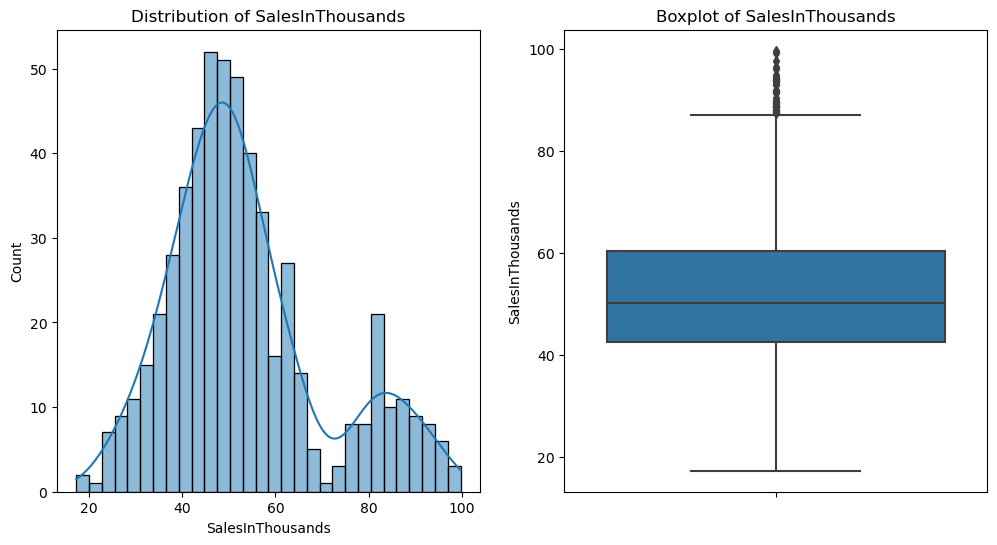

In [33]:
#Produce a histogram of SalesInThousands variable to indicate its distribution 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['SalesInThousands'], bins=30, kde=True)
plt.title('Distribution of SalesInThousands')
#Produce a boxplot of SalesInThousands variable to identify potential outliers
plt.subplot(1, 2, 2)
sns.boxplot(y=df['SalesInThousands'])
plt.title('Boxplot of SalesInThousands')
plt.show()

From the above distributions of SalesInThousands it is observed that most of the sales typically tend to range between 40,000 and 60,000, but there are a few instances when the sales also extend beyond 80,000. In case there is a particular type of promotion strategy that results in sales being beyond 80,000 then it would be an indication that this promotion strategy tends to work best for the fast-food chain.

/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


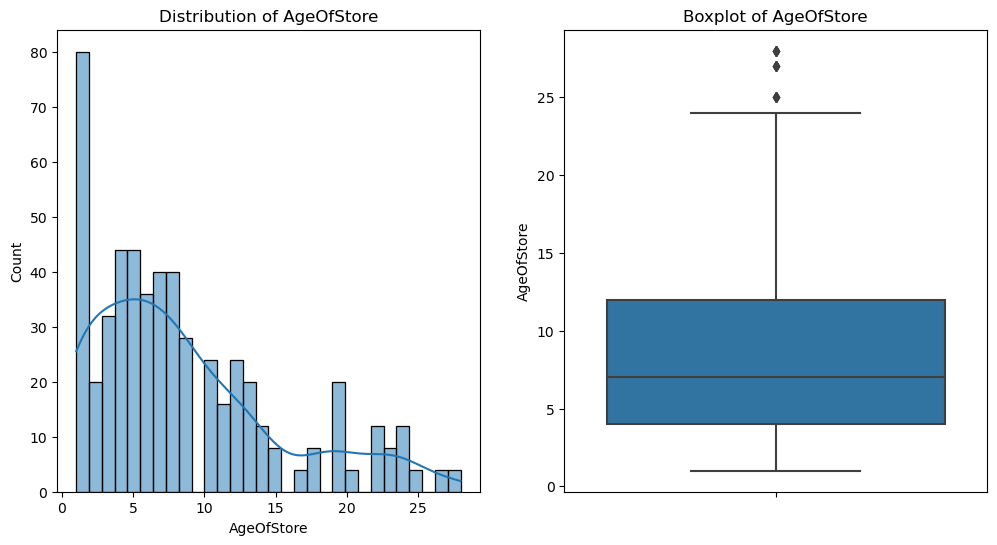

In [34]:
#Produce a histogram of AgeOfStore variable to indicate its distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['AgeOfStore'], bins=30, kde=True)
plt.title('Distribution of AgeOfStore')
#Produce a boxplot of AgeOfStore variable to identify potential outliers
plt.subplot(1, 2, 2)
sns.boxplot(y=df['AgeOfStore'])
plt.title('Boxplot of AgeOfStore')
plt.show()

From the above visualizations it is observed that most of the stores have an age less than 10 years, but there are a few stores which are substantially old as there are some with ages beyond 25 years. Such a discrepancy in age of store can impact sales of the store as well since older stores might have larger sales which in turn can produce biased results for the promotion strategy to be adopted.

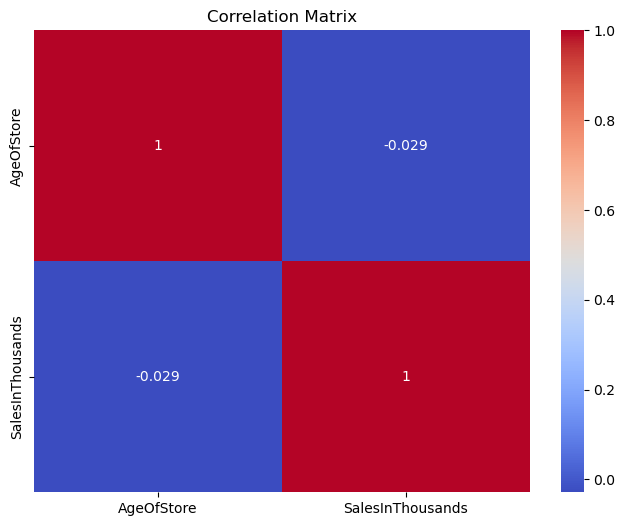

In [35]:
#Plotting a correlation matrix between AgeOfStore and SalesInThousands variables
correlation_matrix = df[['AgeOfStore', 'SalesInThousands']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

From the above visualization it can be observed that SalesInThousands and AgeOfStore variable are not correlated which is useful information since previously mentioned most stores are younger in the dataset which could have resulted in lower sales. Through this correlation matrix this concern is alleviated.

/var/folders/t8/lg4kw7yd6rq90rhc64r9hs980000gn/T/ipykernel_25409/799005125.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Promotion', y='SalesInThousands', data=df, ci=None)
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

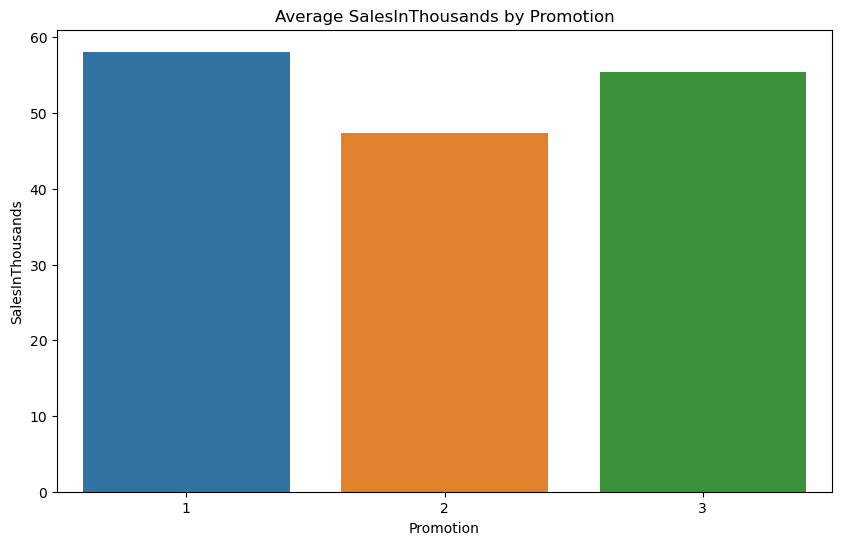

In [36]:
#Barplot indicating the sales produced from various promotion strategies in average
plt.figure(figsize=(10, 6))
sns.barplot(x='Promotion', y='SalesInThousands', data=df, ci=None)
plt.title('Average SalesInThousands by Promotion')
plt.show()

From the above visualization it is observed that on average promotion 2 resulted in the lowest sales, while promotion 1 resulted in the highest sales on average. However, simply based on this visualization its not possible to tell whether this difference is statistically significant.

/var/folders/t8/lg4kw7yd6rq90rhc64r9hs980000gn/T/ipykernel_25409/1456660150.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='MarketSize', y='SalesInThousands', data=df, ci=None)
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDt

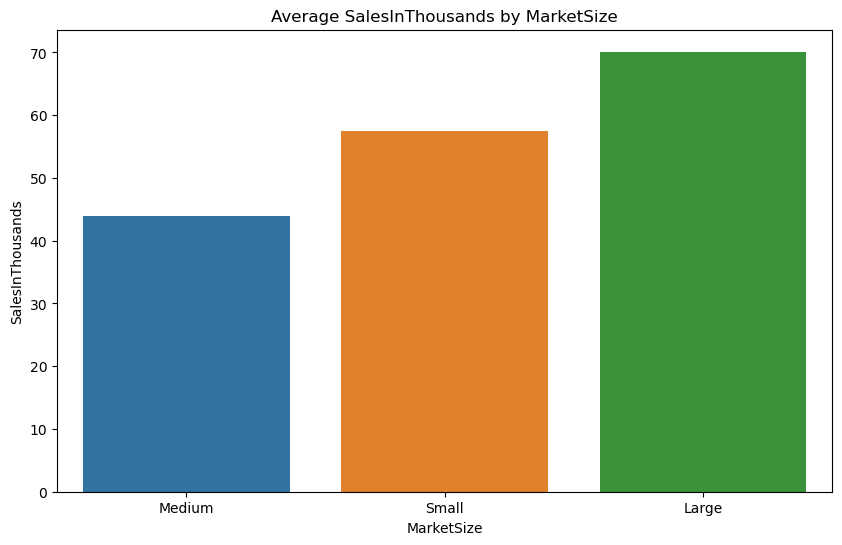

In [37]:
#Barplot indicating the average sales based on various sizes of markets
plt.figure(figsize=(10, 6))
sns.barplot(x='MarketSize', y='SalesInThousands', data=df, ci=None)
plt.title('Average SalesInThousands by MarketSize')
plt.show()

From the visualization above it is observed that largest market sizes tend to produce the highest sales on average, while medium market sizes produce the lowest sales on average. In case most promotions of a certain type are present in a certain type of market size then that could produce biased results. 

/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

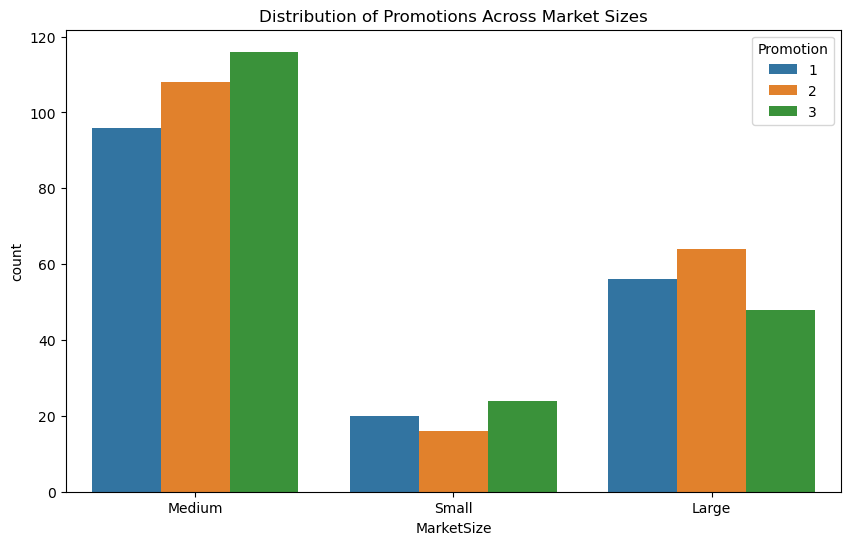

In [38]:
#Side by Side barplot indicating counts of various promotions in different market sizes
plt.figure(figsize=(10, 6))
sns.countplot(x='MarketSize', hue='Promotion', data=df)
plt.title('Distribution of Promotions Across Market Sizes')
plt.legend(title='Promotion')
plt.show()

From the above visualization it is observed that promotion 3 is most present in medium sized markets and promotion 2 is most present in large sized markets. Even though a lot more promotion 2 are present in large market sizes it is still observed that promotion 2 has lowest average sales substantiating that promotion 2 fares worse than other promotions. Consequently, despite promotion 3 being most prevalent in medium sized markets it still has highest average sales implies that promotion 3 is most likely to be the best strategy.

/var/folders/t8/lg4kw7yd6rq90rhc64r9hs980000gn/T/ipykernel_25409/741296171.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='MarketSize', y='SalesInThousands', hue='Promotion', data=df, ci=None)
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtyp

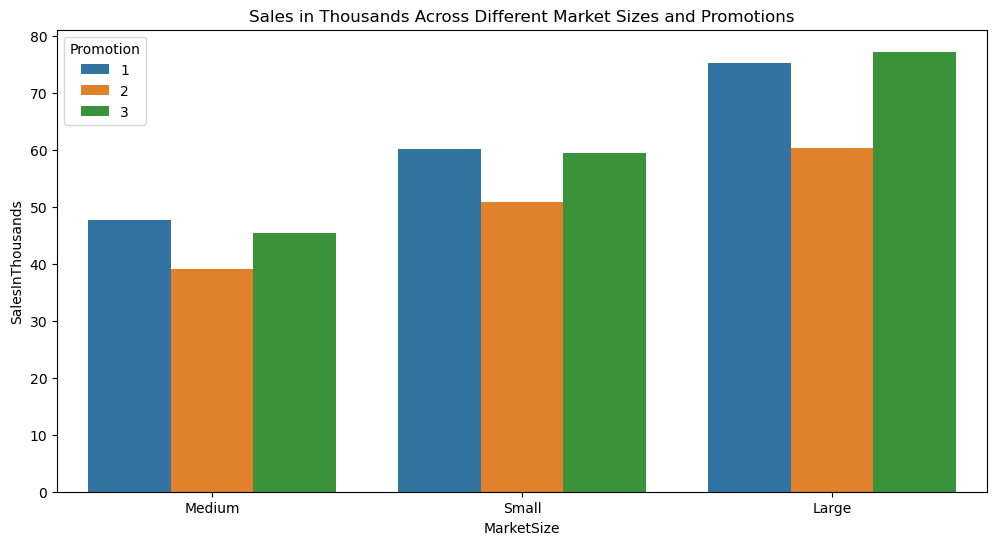

In [39]:
#Side by Side bar chart indicating the sales by market size for each of the promotion strategies
plt.figure(figsize=(12, 6))
sns.barplot(x='MarketSize', y='SalesInThousands', hue='Promotion', data=df, ci=None)
plt.title('Sales in Thousands Across Different Market Sizes and Promotions')
plt.legend(title='Promotion')
plt.show()

From the above visualization it is observed that in the medium market size promotion 1 led to average sales of about 60,000, promotion 2 led to average sales of 40,000, and promotion 3 led to average sales of 50,000. 

In the small market size promotion 1 was most effetive with average sales of 70,000, promotion 2 led to average sales of 55,000, and promotion 3 led to average sales of 60,000. 

In the large market size promotion 3 was most effective with average sales of about 80,000, promotion 1 led to average sales of 75,000, and promotion 2 was least effective with average sales of 60,000. 

Overall large market sizes lead to highest sales.

/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sarthakyadav/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

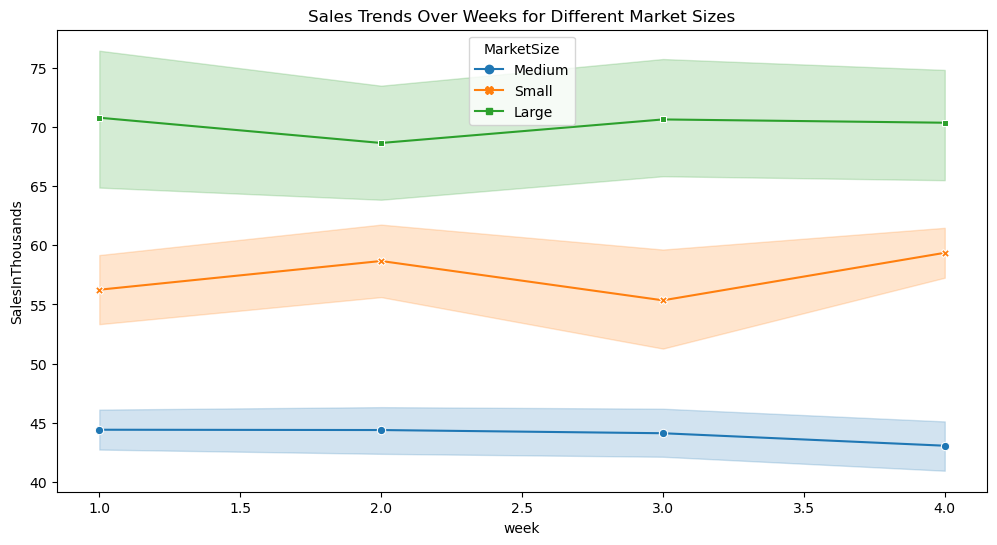

In [40]:
#Line plot indicating sales by market size over various weeks
plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='SalesInThousands', hue='MarketSize', data=df, style='MarketSize', markers=True, dashes=False)
plt.title('Sales Trends Over Weeks for Different Market Sizes')
plt.show()

From the above visualization it is observed that typically sales in medium and large markets don't vary much based on the week, but in case of small markets there is a significant change in sales based on the week, so having too many of a particular promotion strategy in small markets for certain weeks can produce some bias in the results implying that there is a need to carefully tread smaller markets.

## Outlier Analysis

In [41]:
#Define a function to calculate outliers for a given column in a dataframe
def calculate_outliers(df, column):
    #Calculate the first quartile (25th percentile) for the specified column
    Q1 = df[column].quantile(0.25)
    #Calculate the third quartile (75th percentile) for the specified column
    Q3 = df[column].quantile(0.75)
    #Compute the Interquartile Range (distance between the first and third quartiles)
    IQR = Q3 - Q1
    #Determine the lower bound for outliers
    lower_bound = Q1 - 1.5 * IQR
    #Determine the upper bound for outliers
    upper_bound = Q3 + 1.5 * IQR
    #Identify the rows where the column's values are outside the bounds (these are the outliers)
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

#Apply the function to find outliers in 'SalesInThousands' for the 'Small' market size
outliers_small = calculate_outliers(df[df['MarketSize'] == 'Small'], 'SalesInThousands')
#Apply the function to find outliers in 'SalesInThousands' for the 'Medium' market size
outliers_medium = calculate_outliers(df[df['MarketSize'] == 'Medium'], 'SalesInThousands')
#Apply the function to find outliers in 'SalesInThousands' for the 'Large' market size
outliers_large = calculate_outliers(df[df['MarketSize'] == 'Large'], 'SalesInThousands')

#Create a summary dataframe that holds the count of outliers for each market size
outliers_summary = pd.DataFrame({
    'MarketSize': ['Small', 'Medium', 'Large'],
    'OutliersCount': [len(outliers_small), len(outliers_medium), len(outliers_large)]
})

#Define age bins for categorizing the 'AgeOfStore'
age_bins = pd.cut(df['AgeOfStore'], bins=[0, 5, 10, 15, 20, 25, 30], right=True)
#Group the dataframe by the age bins and apply the outlier calculation for 'SalesInThousands'
outliers_by_age = df.groupby(age_bins).apply(lambda x: calculate_outliers(x, 'SalesInThousands')).reset_index(drop=True)
#Count the number of outliers within each age bin and create a new dataframe with this information
outliers_by_age_count = outliers_by_age.groupby(age_bins)['SalesInThousands'].size().reset_index(name='OutliersCount')

#Output both summary dataframes as a tuple
outliers_summary, outliers_by_age_count

/var/folders/t8/lg4kw7yd6rq90rhc64r9hs980000gn/T/ipykernel_25409/804938602.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outliers_by_age = df.groupby(age_bins).apply(lambda x: calculate_outliers(x, 'SalesInThousands')).reset_index(drop=True)
/var/folders/t8/lg4kw7yd6rq90rhc64r9hs980000gn/T/ipykernel_25409/804938602.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outliers_by_age_count = outliers_by_age.groupby(age_bins)['SalesInThousands'].size().reset_index(name='OutliersCount')


(  MarketSize  OutliersCount
 0      Small              1
 1     Medium              2
 2      Large              0,
   AgeOfStore  OutliersCount
 0     (0, 5]             12
 1    (5, 10]             12
 2   (10, 15]              8
 3   (15, 20]              0
 4   (20, 25]              0
 5   (25, 30]              0)

In [42]:
#Define a function that calculates the outlier indices and counts for a given column in a dataframe
def calculate_outliers_with_index(df, column):
    #Calculate the first quartile (Q1) for the specified column
    Q1 = df[column].quantile(0.25)
    #Calculate the third quartile (Q3) for the specified column
    Q3 = df[column].quantile(0.75)
    #Compute the Interquartile Range (IQR) as the difference between Q3 and Q1
    IQR = Q3 - Q1
    #Determine the lower bound value below which data points are considered outliers
    lower_bound = Q1 - 1.5 * IQR
    #Determine the upper bound value above which data points are considered outliers
    upper_bound = Q3 + 1.5 * IQR
    #Identify the outliers as rows where the column's value is outside the bounds
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    #Return the indices of the outliers as a list and the count of outliers
    return outliers.index.tolist(), len(outliers)

#Calculate outliers for the 'Small' market size
#This returns the indices of the outliers and the count of outliers
outliers_small_index, count_small = calculate_outliers_with_index(df[df['MarketSize'] == 'Small'], 'SalesInThousands')
#Calculate outliers for the 'Medium' market size
#This returns the indices of the outliers and the count of outliers
outliers_medium_index, count_medium = calculate_outliers_with_index(df[df['MarketSize'] == 'Medium'], 'SalesInThousands')
#Calculate outliers for the 'Large' market size
#This returns the indices of the outliers and the count of outliers
outliers_large_index, count_large = calculate_outliers_with_index(df[df['MarketSize'] == 'Large'], 'SalesInThousands')

#Create a detailed summary dataframe with the market size, the count of outliers, and the indices of the outlier rows
outliers_detailed_summary = pd.DataFrame({
    'MarketSize': ['Small', 'Medium', 'Large'],
    'OutliersCount': [count_small, count_medium, count_large],
    'OutlierRows': [outliers_small_index, outliers_medium_index, outliers_large_index]
})

#Display the detailed summary dataframe containing outliers information
outliers_detailed_summary

,MarketSize,OutliersCount,OutlierRows
0,Small,1,[190]
1,Medium,2,"[283, 285]"
2,Large,0,[]


In [43]:
#Define a function to calculate outliers within specific age ranges of stores for the 'SalesInThousands' column
def calculate_outliers_by_age(df):
    #Initialize an empty list to store the results for each age range
    results = []
    #Create age bins using pandas 'cut' to categorize the 'AgeOfStore'
    age_bins = pd.cut(df['AgeOfStore'], bins=[0, 5, 10, 15, 20, 25, 30], right=True)
    #Loop over each age range group within the dataframe
    for age_range, group in df.groupby(age_bins):
        #For each group, calculate the outlier indices and count using the previously defined function
        outliers_index, count = calculate_outliers_with_index(group, 'SalesInThousands')
        #Append a dictionary with the age range, number of outliers, and outlier indices to the results list
        results.append({'AgeRange': age_range, 'OutliersCount': count, 'OutlierRows': outliers_index})
    #Convert the results list to a pandas DataFrame before returning
    return pd.DataFrame(results)

#Calculate the outliers for each age range group within the dataframe and store the detailed results
outliers_by_age_detailed = calculate_outliers_by_age(df)
#Display the resulting detailed outliers by age dataframe
outliers_by_age_detailed

/var/folders/t8/lg4kw7yd6rq90rhc64r9hs980000gn/T/ipykernel_25409/3097565603.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for age_range, group in df.groupby(age_bins):


,AgeRange,OutliersCount,OutlierRows
0,"(0, 5]",3,"[111, 144, 154]"
1,"(5, 10]",15,"[80, 81, 82, 83, 132, 133, 134, 135, 149, 150,..."
2,"(10, 15]",13,"[84, 85, 86, 87, 96, 97, 98, 99, 116, 117, 118..."
3,"(15, 20]",1,[114]
4,"(20, 25]",0,[]
5,"(25, 30]",0,[]


## ANOVA A/B Test

__Null Hypothesis:__ There is no difference between the promotion strategies, i.e., mean of sales from promotions 1, 2, and 3 are all the same.

__Alternative Hypothesis:__ At least mean of sales from one of the promotion strategies (1, 2, 3) is different.

In [44]:
sales_data = [df[df['Promotion'] == i]['SalesInThousands'] for i in range(1, 4)]

#Step 1: Normality Test
#Perform Shapiro-Wilk test on each group (Promotion)
normality_results = [shapiro(group) for group in sales_data]

#Step 2: Homogeneity of Variances Test
#Perform Levene's test across groups
levene_result = levene(*sales_data)

normality_results, levene_result

([ShapiroResult(statistic=0.9152998328208923, pvalue=1.977244323825289e-08),
  ShapiroResult(statistic=0.9145087003707886, pvalue=5.456124441138854e-09),
  ShapiroResult(statistic=0.9207682609558105, pvalue=1.4994489205832906e-08)],
 LeveneResult(statistic=1.2696787527507418, pvalue=0.2817514565692118))

From the above Shapiro tests it is observed that the p-value being less than the significance level of 0.05 implies that all the above promotion distributions differ significantly from normality. 

From the Levene test it is observed that the p-value being greater than the significance level of 0.05 implies that all the promotion strategies have similar variances.

In [45]:
#Fit an Ordinary Least Squares regression model using 'SalesInThousands' as the dependent variable and 'Promotion' as the independent variable
model = ols('SalesInThousands ~ C(Promotion)', data=df).fit()
#Extract the residuals from the model
residuals = model.resid
#Perform the Shapiro-Wilk test for normality on the residuals
residuals_normality = shapiro(residuals)
#Output the results of the Shapiro-Wilk test
residuals_normality

ShapiroResult(statistic=0.922081708908081, pvalue=3.154390400244417e-16)

From the above results as the p-value is less than the significance level of 0.05 this implies that the residuals of the model don't follow a normal distribution.

In [46]:
#Perform the Kruskal-Wallis H-test on the sales data
kruskal_result = kruskal(*sales_data)
kruskal_result

KruskalResult(statistic=53.29475169322799, pvalue=2.6741866266697816e-12)

As the p-value is less than the significance level of 0.05 it is observed that the null hypothesis that the mean of sales from promotion strategies 1, 2, and 3 are the same is rejected. This implies that the mean of sales of at least one promotion strategy 1, 2, or 3 is different from the others indicating some promotion strategies are better than the others for the fast-food chain.

In [47]:
#Installing posthocs package
!pip install scikit_posthocs

In [48]:
#Perform Dunn's post-hoc test to analyze the pairwise differences between sales for the promotion strategies
p_values = posthoc_dunn(df, val_col='SalesInThousands', group_col='Promotion', p_adjust='bonferroni')
p_values

,1,2,3
1,1.000000e+00,6.461842e-12,1.458660e-01
2,6.461842e-12,1.000000e+00,7.083069e-07
3,1.458660e-01,7.083069e-07,1.000000e+00


From the above analysis it is observed that the difference of mean of sales of promotion strategies 1 and 3 are statistically insignificant, i.e., both these promotion strategies produce similar sales for the fast-food chain. 

From the above analysis it is observed that the difference of mean of sales of promotion strategies 1 and 2 are statistically significant, i.e., both these promotion strategies produce different sales for the fast-food chain. 

From the above analysis it is observed that the difference of mean of sales of promotion strategies 2 and 3 are statistically significant, i.e., both these promotion strategies produce different sales for the fast-food chain.

## Conclusion

Based on the entire analysis conducted it is observed that promotion strategies 1, and 3 are equally effective for the fast-food chain, while promotion strategy 2 isn't, because from the various visualizations conducted in EDA the sales from promotion strategy 2 was the lowest in comparison to those from promotion strategies 1 and 3, and given that promotion strategy 2 has a mean of sales statistically significantly different from mean of sales from promotion strategies 1, and 3 indicates that promotion strategy 2 must certainly not be applied by the fast-food chain. Between promotion strategy 1, and 3 either can be applied since both produce mean of sales not different at a statistically significant level. 

## Extra

In case the cost of implementation of each of the promotion strategies was given then the below analysis could yield which promotion strategy is most suitable for the fast-food chain.

In [49]:
#Assume hypothetical costs for each promotion for demonstration
#Let's say the costs are 500, 800, and 700 units for promotions 1, 2, and 3 respectively
costs = {1: 500, 2: 800, 3: 700}

#Calculate average sales for each promotion
average_sales = df.groupby('Promotion')['SalesInThousands'].mean().reset_index()

#Map the hypothetical costs to each promotion
average_sales['Cost'] = average_sales['Promotion'].map(costs)

#Calculate the efficiency score (AverageSales / Cost)
average_sales['EfficiencyScore'] = average_sales['SalesInThousands'] / average_sales['Cost']

#Find the promotion with the highest efficiency score
best_promotion = average_sales.loc[average_sales['EfficiencyScore'].idxmax()]
best_promotion

Promotion             1.000000
SalesInThousands     58.099012
Cost                500.000000
EfficiencyScore       0.116198
Name: 0, dtype: float64